# Segment Anything Model Finetuning for Remote Sensing Applications


In this project you will be asked to segment sidewalks from satellite imagery. The importance of remote sensing and its associated job market is growing rapidly. Remote sensing powers, weather prediction, agriculture, urban planning, defense and many other applications. 

Lately, we have observed the advent of very large foundational models in NLP applications - sometimes these models result in  hundreds of billions of parameters - for example the [GPT-3](https://arxiv.org/abs/2005.14165) model that has 175 billion parameters. Can we do the same for computer vision applications ?  An example of a positive answer to this problem is the Segmenting Anything Model (SAM).  

In [3]:
import os
from transformers import SamModel, SamProcessor
import torch
import numpy as np
import tifffile
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from pycocotools.coco import COCO

## Background

![](../images/sam.png)

Read and experiment with [the SAM implementation](https://segment-anything.com/) and [the SAM paper](https://arxiv.org/abs/2304.02643).


## Milestone 1: Get to know Geographical Information Systems (GIS) and set up your development environment

See [this tutorial](https://docs.qgis.org/3.34/en/docs/gentle_gis_introduction/index.html) that is best to be followed in a desktop installation of [QGIS](https://qgis.org/en/site/). 

Use the [example docker container](https://github.com/pantelis/artificial-intelligence) if you have access to a local NVIDIA GPU. Note that you need to do the project in Pytorch and you need to edit the `devcontainer.json` file to point to the right container for PyTorch.   

In addition to python scripts you will also need python notebooks to experiment and visualize the SAM model outputs as well as geospatial data. The suggested container ships with [Jupyter](https://jupyter.org/) and if you use [Google Colab](https://colab.research.google.com/) you are obviously using notebooks.  

ScreenShots

![](../images/Container.png)

![](../images/qgis.png)

## Milestone 2: Replicate SAM implementation for satellite imagery

The SAM implementation for remote sensing applications is based on [this package](https://samgeo.gishub.org/). Go over the following video and replicate the workflow in your environment for the imagery used by the author.    

https://www.youtube.com/watch?v=YHA_-QMB8_U

The notebook based environment makes it very easy to experiment with the SAM model and the workflow. 

This [desktop QGIS plugin](https://github.com/BjornNyberg/Geometric-Attributes-Toolbox/wiki/User-Guide#segment-anything-model) is also available to help you experiment with the SAM model.

## Milestone 3: Finetune the SAM model for the sidewalks dataset

Use the sidewalk dataset (this is currently being prepared and will be released soon) and finetune the SAM model for this dataset. Follow these instructions to do so. 

https://www.youtube.com/watch?v=83tnWs_YBRQ


Use loss functions and segementation quality metrics that are suitable for roads and sidewalks. You can see [this reference for guidance](https://www.sciencedirect.com/science/article/pii/S1569843222003478).  Avoid going into a rabbit hole of developing your own metrics - there are many metrics that are suitable for this task and you just need to be aware of them and use them. Note that sidewalks are many times more difficult to segment than roads due to their narrow width and the fact that they are often occluded by trees and other objects.

These include: 

- [Intersection over Union](https://en.wikipedia.org/wiki/Jaccard_index)
- [Dice coefficient](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient)
- [F1 score](https://en.wikipedia.org/wiki/F-score)


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_path = os.path.join('..', 'data')
label_path = os.path.join(data_path, 'Label')
val_path = os.path.join(data_path, 'Test')
val_label_path = os.path.join(label_path, 'Test')
DVRPC_val_path = os.path.join(data_path,'DVRPC_val.json')
val_files = [f for f in os.listdir(val_path) if (f.endswith('.tif') and np.max(tifffile.imread(os.path.join(val_label_path, f))) > 0)]

In [5]:
sam_processor = SamProcessor.from_pretrained('facebook/sam-vit-base')
sam_model = SamModel.from_pretrained('facebook/sam-vit-base')

sam_model.load_state_dict(torch.load(os.path.join('..', 'models', 'finetune_sam_base_epoch_001.pt')))

<All keys matched successfully>

In [6]:
class SidewalkDatasetPlain(Dataset):
    def __init__(self, data_path: str, label_path: str, files: list, processor, transform=None):
        self.data_path = data_path
        self.label_path = label_path
        self.files = files
        self.processor = processor
        self.transform = transform

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        img = tifffile.imread(os.path.join(self.data_path, self.files[idx]))
        label = tifffile.imread(os.path.join(self.label_path, self.files[idx]))
        if self.transform:
            img, label = self.transform(img, label)
        inputs = self.processor(img, return_tensors='pt')
        # remove batch dimension which the processor adds by default
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}
        inputs['labels'] = torch.tensor(label).unsqueeze(0)
        inputs['original_img'] = img
        return inputs

class SidewalkDatasetBboxPrompt(Dataset):
    def __init__(self, data_path: str, coco_file: str, processor, transform=None):
        self.data_path = data_path
        self.coco = COCO(coco_file)
        self.ann_ids = self.coco.getAnnIds()
        self.processor = processor
        self.transform = transform

    def __len__(self):
        return len(self.ann_ids)
    
    def __getitem__(self, idx):
        ann = self.coco.loadAnns(self.ann_ids[idx])[0]
        img = tifffile.imread(os.path.join(self.data_path, self.coco.imgs[ann['image_id']]['file_name']))
        label = self.coco.annToMask(ann)
        bbox = ann['bbox']
        if self.transform:
            img, label = self.transform(img, label)
        inputs = self.processor(img, input_boxes=[[bbox]], return_tensors='pt')
        # remove batch dimension which the processor adds by default
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}
        inputs['labels'] = torch.tensor(label).unsqueeze(0)
        inputs['original_img'] = img
        return inputs

In [7]:
val_dataset_plain = SidewalkDatasetPlain(val_path, val_label_path, val_files, sam_processor)
val_dataset_prompt = SidewalkDatasetBboxPrompt(val_path, DVRPC_val_path, sam_processor)

val_dataloader_plain = DataLoader(val_dataset_plain, batch_size=2, shuffle=True)
val_dataloader_prompt = DataLoader(val_dataset_prompt, batch_size=2, shuffle=True)

loading annotations into memory...
Done (t=0.31s)
creating index...
index created!


In [8]:
sam_model.to(device).eval()

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

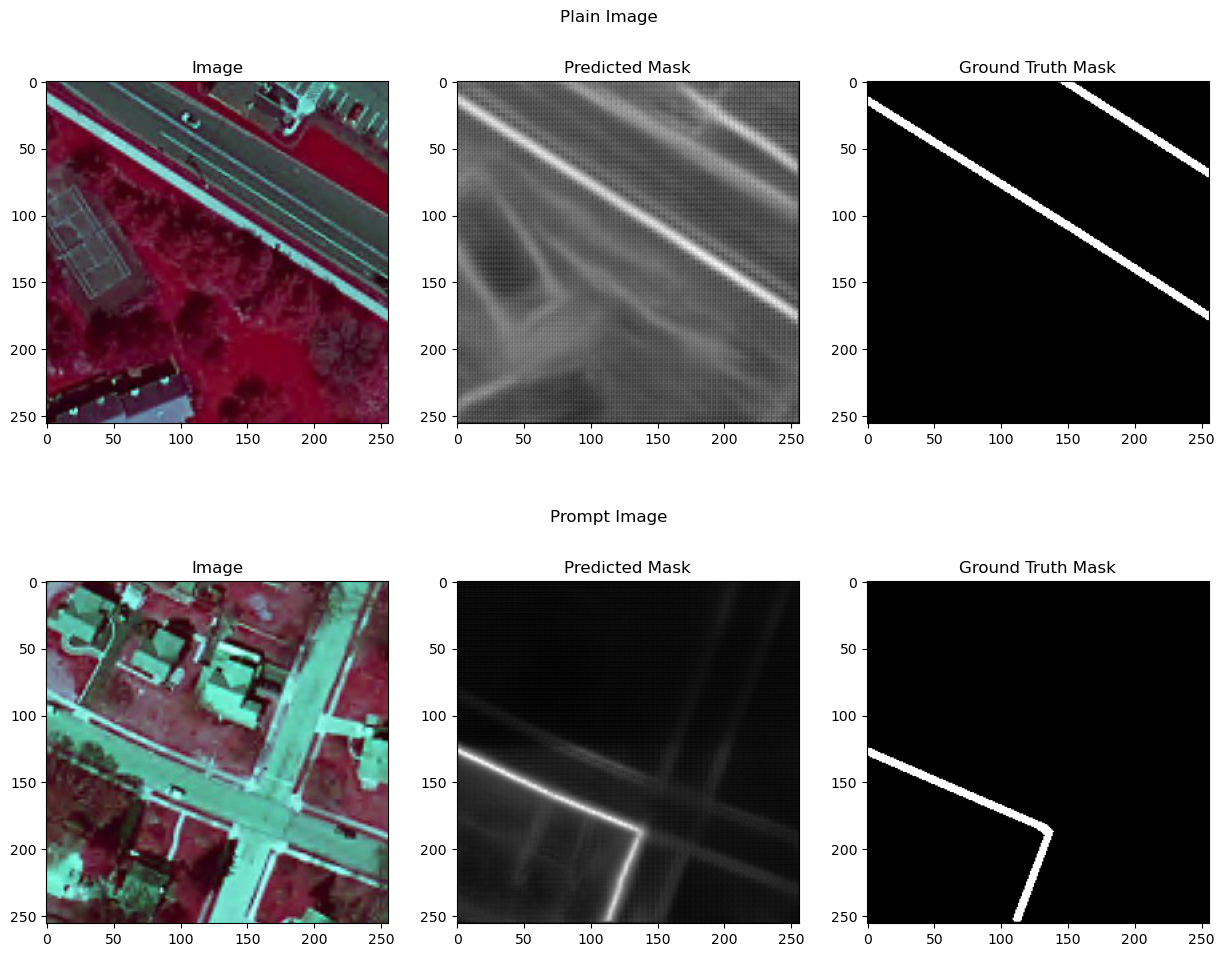

In [10]:
# Visualize the results
sample1 = next(iter(val_dataloader_plain))
with torch.no_grad():
    outputs1 = sam_model(pixel_values=sample1['pixel_values'].to(device),
                        multimask_output=False)
    predicted_masks1 = outputs1.pred_masks.squeeze(1)
    ground_truth_masks1 = sample1['labels'].float().to(device)

sample2 = next(iter(val_dataloader_prompt))
with torch.no_grad():
    outputs2 = sam_model(pixel_values=sample2['pixel_values'].to(device),
                         input_boxes=sample2['input_boxes'].to(device),
                        multimask_output=False)
    predicted_masks2 = outputs2.pred_masks.squeeze(1)
    ground_truth_masks2 = sample2['labels'].float().to(device)

%matplotlib inline
fig = plt.figure(figsize=(15, 10))
subfigs = fig.subfigures(2, 1)
subfigs[0].suptitle('Plain Image')
axs = subfigs[0].subplots(1, 3)
axs[0].imshow(sample1['original_img'][0].cpu().numpy())
axs[0].set_title('Image')
axs[1].imshow(predicted_masks1[0].cpu().numpy().squeeze(axis=0), cmap='gray')
axs[1].set_title('Predicted Mask')
axs[2].imshow(ground_truth_masks1[0].cpu().numpy().squeeze(axis=0), cmap='gray')
axs[2].set_title('Ground Truth Mask')

subfigs[1].suptitle('Prompt Image')
axs = subfigs[1].subplots(1, 3)
axs[0].imshow(sample2['original_img'][0].cpu().numpy())
axs[0].set_title('Image')
axs[1].imshow(predicted_masks2[0].cpu().numpy().squeeze(axis=0), cmap='gray')
axs[1].set_title('Predicted Mask')
axs[2].imshow(ground_truth_masks2[0].cpu().numpy().squeeze(axis=0), cmap='gray')
axs[2].set_title('Ground Truth Mask')

plt.show()